<h1>Data Preprocessing</h1>

In [15]:
import scipy.io as sio
from sklearn import preprocessing
import csv
import pandas as pd
import numpy as np

# Spam data
spam_train_X = sio.loadmat('/Users/aiswaryasankar/Desktop/cs189/hw5/dist/spam_data.mat')['training_data']
spam_train_y = sio.loadmat('/Users/aiswaryasankar/Desktop/cs189/hw5/dist/spam_data.mat')['training_labels']
spam_test = sio.loadmat('/Users/aiswaryasankar/Desktop/cs189/hw5/dist/spam_data.mat')['test_data']

# Census data
census_train_df = pd.read_csv('/Users/aiswaryasankar/Desktop/cs189/hw5/hw5_census_dist/train_data.csv')
census_test_df = pd.read_csv('/Users/aiswaryasankar/Desktop/cs189/hw5/hw5_census_dist/test_data.csv')

# Titanic data
titanic_test_df = pd.read_csv('/Users/aiswaryasankar/Desktop/cs189/hw5/hw5_titanic_dist/titanic_testing_data.csv')
titanic_train_df = pd.read_csv('/Users/aiswaryasankar/Desktop/cs189/hw5/hw5_titanic_dist/titanic_training.csv')

<h2> Titanic Data Preprocessing </h2>

In [17]:
# Impute missing values, use fillna

def fill_null(var):
    titanic_train_df[var] = titanic_train_df[var].fillna(titanic_train_df[var].median())
    
def titanic_preprocess(data):
    # Pass in each of the numerical columns and fill with the median
    vals = ['pclass', 'age', 'sibsp', 'parch', 'fare']
    for val in vals:
        fill_null(val)
    
    # Note that the embarked column also has missing values
    # titanic_train_df['embarked'] = titanic_train_df['embarked'].fillna('S')
    data['embarked'] = data['embarked'].fillna('S')
    
    del data['cabin']
    del data['ticket']
    data = pd.get_dummies(data)
    return data
    
titanic_train_df = titanic_preprocess(titanic_train_df)

# Split the data into data and labels
titanic_train_labels = titanic_train_df['survived']
titanic_train_df = titanic_train_df.iloc[:, 1:]

titanic_test_df = titanic_preprocess(titanic_test_df)

# Train_test split
from sklearn.model_selection import train_test_split
titanic_train_df, titanic_val_df, titanic_train_labels, titanic_val_labels = train_test_split(titanic_train_df, titanic_train_labels, test_size=0.2, random_state=42)

<h2>Census Data Preprocessing</h2>

In [18]:
# All the variables have the same count but there are ? instead
# Thus first go through and change the ? into NA
def census_preprocess(data):
    data = data.replace('?', np.nan)

    # Convert all the categorical variables into binary
    # I'm going to remove native_country before doing this because too many native countries
    del data['native-country']
    data = pd.get_dummies(data)
    return data
    
census_train_df = census_preprocess(census_train_df)
census_train_labels = census_train_df['label']
print(census_train_df.shape)
print(census_train_labels.shape)
del census_train_df['label']

census_test_df = census_preprocess(census_test_df)

# Train test split
census_train_df, census_val_df, census_train_labels, census_val_labels = train_test_split(census_train_df, census_train_labels, test_size=0.2, random_state=42)

# Observation native-country_Holand-Netherlands not in the test columns

(32724, 65)
(32724,)


<h2>Spam Data Preprocessing</h2>

In [19]:
# No real preprocessing needed here?
# Convert the matrices into DataFrames

spam_train_df = pd.DataFrame(spam_train_X)
spam_test_df = pd.DataFrame(spam_test
                           )
# spam_train_labels = pd.DataFrame(spam_train_y.T)
print(spam_train_y[0])
spam_train_labels = pd.Series(spam_train_y[0])

print(spam_train_df.shape)
print(spam_train_labels.shape)
spam_train_df, spam_val_df, spam_train_labels, spam_val_labels = train_test_split(spam_train_df, 
                                                                                  spam_train_labels, 
                                                                                  test_size=0.2, 
                                                                                  random_state=42)

[1 1 1 ..., 0 0 0]
(23702, 32)
(23702,)


<h1>Decision Tree</h1>

In [36]:
import collections 
import timeit

class Node():
    def __init__(self, feature, value, left, right, label):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.label = label
        
        
class DecisionTree():
    
    def __init__(self, train_data, train_labels, val_data, val_labels):
        self.root = Node(None, None, None, None, None)
        self.train_data = train_data
        self.val_data = val_data
        self.train_labels = train_labels
        self.val_labels = val_labels
        self.numPoints = 0
        
    def entropy(self, numNeg, numPos):
        if numNeg == 0 or numPos == 0:
            return 0
        else:
            total = numNeg + numPos
            return -(numPos/total) * math.log(numPos/total, 2) - (numNeg/total) * math.log(numNeg/total, 2)
        
    def weighted_entropy(self, left_label_hist, right_label_hist):
        # This method needs to compute -(p/n+p)log(p/n+p) - (n/n+p)log(n/n+p)
        numLeftNeg = left_label_hist[0]
        numLeftPos = left_label_hist[1]
        numRightNeg = right_label_hist[0]
        numRightPos = right_label_hist[1]
        numLeft = numLeftNeg + numLeftPos
        numRight = numRightNeg + numRightPos
        total = numLeft + numRight
        
        leftEntropy = self.entropy(numLeftNeg, numLeftPos)
        rightEntropy = self.entropy(numRightNeg, numRightPos)
        weightedEntropy = (numLeft / total) * leftEntropy + (numRight / total) * rightEntropy
        return weightedEntropy
    
    def segmenter(self, data, labels):
        data, labels = (list(x) for x in zip(*sorted(zip(data, labels), key=lambda pair: pair[0])))
        rightNeg = labels.count(0.0)
        rightPos = labels.count(1.0)
        leftNeg, leftPos = 0, 0
        
        dictionary = collections.OrderedDict()
        for key, value in zip(data, labels):
            dictionary.setdefault(key, []).append(value)

        min_entropy = float('inf')
        best_split = -1.0
        
        for key, value in dictionary.items():  
            # Increment the left by the occurences of each kind and decrememnt from the right
            leftNeg += value.count(0.0)
            leftPos += value.count(1.0)
            rightNeg -= value.count(0.0)
            rightPos -= value.count(1.0)

            key_entropy = self.weighted_entropy((leftNeg, leftPos), (rightNeg, rightPos))
            
            if key_entropy < min_entropy:
                min_entropy = key_entropy
                best_split = key
                
        return [best_split, min_entropy]
        
    
    def train(self, root, data, labels, curLevel, maxLevel, percentFeatures):  
        
        if curLevel > maxLevel or data.empty or labels.empty:
            labels = labels.tolist()
            bestLabel = np.argmax([labels.count(0.0), labels.count(1.0)])
            root.label = bestLabel
            self.numPoints += 1
            #print('creating a leaf with label ' + str(bestLabel) + " at depth " + str(curLevel))
        else:
            best_overall_feature = 'a'
            best_overall_split_entropy = float('inf')
            best_overall_split_value = float('inf')
            
            # This loop iterates over all of the columns and returns the best split
            # For random forest I need to choose a random subsample of size √len(data.columns)
            # for each split
            # Thus I will compute this random subsample of features and iterate over that
            # I will print out this list each time to check that I am using a random sample
            numFeatures = int(percentFeatures * len(data.columns))
            randCols = [data.columns[i] for i in 
                        sorted(random.sample(range(len(data.columns)), numFeatures)) ]
            
            start = timeit.default_timer()
            for col in randCols:
                
                value, best_split_entropy = self.segmenter(data[col], labels)
                
                if best_split_entropy < best_overall_split_entropy:
                    best_overall_feature = col
                    best_overall_split_entropy = best_split_entropy
                    best_overall_split_value = value
                #print('best split and entropy are ')
                #print(best_overall_split_value)
            stop = timeit.default_timer()     
            #print (stop - start) 
            #print('best feature split entropy: ' + str(best_overall_split_entropy))
            #print('best feature split feature: ' + best_overall_feature)
            #print('best feature splitting value: ' + str(best_overall_split_value))
            #print('_____________________________')

            # Join data with the label and split according to the split value
            # Then separate out the data from the label again
            # print('best overall feature is ' + str(best_overall_feature) + ' at level ' + str(curLevel))

            data['label'] = labels
            leftSet = data[data [best_overall_feature] <= best_overall_split_value]
            rightSet = data[data [best_overall_feature] > best_overall_split_value]
            
            leftLabels = leftSet['label']
            rightLabels = rightSet['label']
            del leftSet['label']
            del rightSet['label']
            
            #print('creating a node at level ' + str(curLevel) + ' with feature ' + best_overall_feature 
            #      + ' and split value ' + str(best_overall_split_value))
            
            root.feature = best_overall_feature
            root.value = best_overall_split_value
            root.left = Node(None, None, None, None, None)
            self.train(root.left, leftSet, leftLabels, curLevel+1, maxLevel, percentFeatures)
            root.right = Node(None, None, None, None, None)
            self.train(root.right, rightSet, rightLabels, curLevel+1, maxLevel, percentFeatures)
            
    def predict(self, data, node):
        #print('in predict')
        if node.right is None and node.left is None:
            #print('The label is ' + str(node.label))
            #if (node.label == 0):
            #    print("Therefore the label is spam")
            #else:
            #    print("Therefore the label is ham")
            return node.label
        else:
            #print('The feature is ' + str(node.feature))
            #print('The value is ' + str(node.value))
            #print('The data is ' + str(data[node.feature]))
            #print('done data')
            if data [node.feature] <= node.value:
                #print(str(node.feature) + ' <= ' + str(node.value) )
                return self.predict(data, node.left)
            else:
                #print(str(node.feature) + ' > ' + str(node.value) )
                return self.predict(data, node.right)
        
    def computeAccuracy(self, isTrain):
        numRight = 0
        if isTrain:
            for index, row in self.train_data.iterrows():
                if (self.predict(row, self.root) == self.train_labels[index]):
                    numRight += 1
            return numRight / len(self.train_labels)
        
        else:
            for index, row in self.val_data.iterrows():
                if (self.predict(row, self.root) == self.val_labels[index]):
                    numRight += 1
            
            return numRight / len(self.val_labels)

<h2>Titanic Decision Tree</h2>

In [37]:
# Create decision tree with all the data
titanic_classifier = DecisionTree(titanic_train_df, titanic_train_labels,
                                 titanic_val_df, titanic_val_labels)

# Train the decision tree with different parameters for number of levels
# After training the model find the training and validation accuracies

levels = [3, 5, 7]

for level in levels:
    if ('label' in titanic_train_df.columns):
        del titanic_train_df['label']
    titanic_classifier.train(titanic_classifier.root, titanic_train_df, 
                             titanic_train_labels, 0, level, 1)
    titanicTrainingAcc = titanic_classifier.computeAccuracy(True)
    titanicValAcc = titanic_classifier.computeAccuracy(False)
    print('training acc is ' + str(titanicTrainingAcc))
    print('validation acc is ' + str(titanicValAcc))


/Users/aiswaryasankar/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


training acc is 0.8125
validation acc is 0.815
training acc is 0.83875
validation acc is 0.81
training acc is 0.855
validation acc is 0.795


<h2>Titanic Submission</h2>

In [38]:
if ('label' in titanic_train_df.columns):
    del titanic_train_df['label']
    
titanic_classifier.train(titanic_classifier.root, titanic_train_df, 
                             titanic_train_labels, 0, 3, 1)
pred = []
for index, row in titanic_test_df.iterrows():
    pred.append(titanic_classifier.predict(row, titanic_classifier.root))

from collections import OrderedDict

indexArr = [i for i in range(1, len(pred)+1)]
d = OrderedDict()
d["Id"] = indexArr
d["Category"] = pred

output = pd.DataFrame(data=d)
output.to_csv('PredTitanic.csv', index=False)

deleted label


/Users/aiswaryasankar/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [39]:
def printTree(node, level):
    if node.right == None and node.left == None:
        print('\t' * level + str(node.label))
    else:
        print('\t' * level + str(node.feature) + " " + str(node.value))
        printTree(node.left, level+1)
        printTree(node.right, level+1)
        
printTree(titanic_classifier.root, 0)

sex_female 0
	age 3.0
		sibsp 1.0
			fare 13.775
				0
				1
			pclass 3.0
				0
				0
		pclass 1.0
			age 54.0
				0
				0
			age 32.0
				0
				0
	pclass 2.0
		embarked_S 0
			pclass 1.0
				1
				1
			age 58.0
				1
				1
		fare 22.3583
			fare 7.25
				1
				1
			age 5.0
				0
				0


<h2>Census Decision Tree</h2>

In [40]:
# Create decision tree with all the data
census_classifier = DecisionTree(census_train_df, census_train_labels,
                                 census_val_df, census_val_labels)

# Train the decision tree with different parameters for number of levels
# After training the model find the training and validation accuracies

levels = [1]

for level in levels:
    if ('label' in census_train_df.columns):
        del census_train_df['label']

    census_classifier.train(census_classifier.root, census_train_df, 
                             census_train_labels, 0, level, 1)
    censusTrainingAcc = census_classifier.computeAccuracy(True)
    censusValAcc = census_classifier.computeAccuracy(False)
    print('training acc is ' + str(censusTrainingAcc))
    print('validation acc is ' + str(censusValAcc))


/Users/aiswaryasankar/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


training acc is 0.8064861148248597
validation acc is 0.7943468296409473


<h2>Census Tree Depth</h2>

In [42]:
depths = [2, 3, 4, 5, 10, 20]
val_acc = []

for depth in depths:
    #Botch fix
    if ('label' in census_train_df.columns):
        del census_train_df['label']
        
    census_classifier.train(census_classifier.root, census_train_df, 
                             census_train_labels, 0, depth, 1)
    print(census_classifier.computeAccuracy(False))
    val_acc.append(census_classifier.computeAccuracy(False))

/Users/aiswaryasankar/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.839266615737204
0.839266615737204
0.8446142093200917
0.8456837280366692
0.8508785332314744


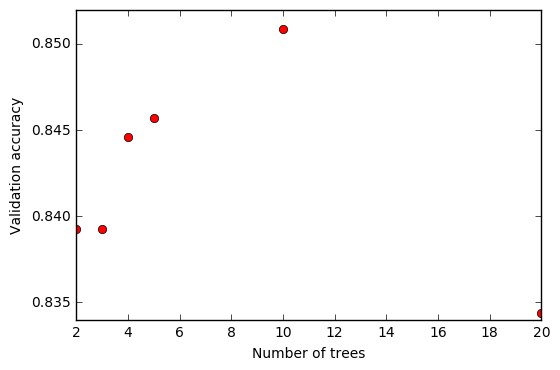

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
val_acc = [0.839266615737204, 0.839266615737204, 0.8446142093200917, 0.8456837280366692, 0.8508785332314744, 0.8343773873185638]
depths = [2,3,4,5,10,20]

plt.plot(depths, val_acc, 'ro')
plt.xlabel('Number of trees')
plt.ylabel("Validation accuracy")

<h2>Census Submission</h2>

In [32]:
pred = []
for index, row in census_test_df.iterrows():
    pred.append(census_classifier.predict(row, census_classifier.root))

from collections import OrderedDict

indexArr = [i for i in range(1, len(pred)+1)]
d = OrderedDict()
d["Id"] = indexArr
d["Category"] = pred

output = pd.DataFrame(data=d)
output.to_csv('PredictionsCensus.csv', index=False)

<h2>Spam Decision Tree</h2>

In [52]:
spam_classifier = DecisionTree(spam_train_df, spam_train_labels,
                                 spam_val_df, spam_val_labels)

# Train the decision tree with different parameters for number of levels
# After training the model find the training and validation accuracies

levels = [10]

for level in levels:
    if ('label' in spam_train_df.columns):
        del spam_train_df['label']
        
    spam_classifier.train(spam_classifier.root, spam_train_df, 
                             spam_train_labels, 0, level, 1)
    spamTrainingAcc = spam_classifier.computeAccuracy(True)
    spamValAcc = spam_classifier.computeAccuracy(False)
    print('training acc is ' + str(spamTrainingAcc))
    print('validation acc is ' + str(spamValAcc))

/Users/aiswaryasankar/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


training acc is 0.7884605242339539
validation acc is 0.7717781058848344


<h2>Spam Prediction Splits</h2>

In [81]:
# Choose a data point from spam and ham
#for i in range(20):
#    if spam_classifier.predict(spam_train_df.iloc[i], spam_classifier.root) == 'ham':
#        print(i)
sample1 = spam_train_df.iloc[9]
sample2 = spam_train_df.iloc[4]

spam_classifier.predict(sample1, spam_classifier.root)
spam_classifier.predict(sample2, spam_classifier.root)

in predict
28 > 0.0
in predict
13 <= 0.0
in predict
3 <= 0.0
in predict
29 > 0.0
in predict
28 <= 2.0
in predict
15 <= 1.0
in predict
9 <= 0.0
in predict
31 <= 0.0
in predict
26 <= 0.0
in predict
29 > 3.0
in predict
27 <= 0.0
in predict
Therefore the label is spam
in predict
28 > 0.0
in predict
13 <= 0.0
in predict
3 <= 0.0
in predict
29 <= 0.0
in predict
28 <= 29.0
in predict
6 <= 0.0
in predict
26 <= 0.0
in predict
0 <= 0.0
in predict
28 > 1.0
in predict
16 <= 0.0
in predict
25 > 1.0
in predict
Therefore the label is ham


1

<h2>Spam Submission</h2>

In [54]:
pred = []
for index, row in spam_test_df.iterrows():
    pred.append(spam_classifier.predict(row, spam_classifier.root))

from collections import OrderedDict

indexArr = [i for i in range(len(pred))]
d = OrderedDict()
d["Id"] = indexArr
d["Category"] = pred

output = pd.DataFrame(data=d)
output.to_csv('PredictionsSpam.csv', index=False)

<h2> Random Forest</h2>

In [55]:
class RandomForest():
    
    def __init__(self, train_df, train_labels, val_df, val_labels):
        self.train_df = train_df
        self.train_labels = train_labels
        self.val_df = val_df
        self.val_labels = val_labels
        self.forest = []
        
    def train(self, data, labels, numTrees, featuresPerSplit, dataSubsample):
        
        for i in range(numTrees):
            # Create the data subset to use for this tree
            # First I need to combine the data and the labels in order to make sure that I 
            # subsample both of the datasets at the same time and they match up appropriately
            
            merged = pd.concat([data, labels], axis=1)
            
            # Now I need to subsample a number of the rows
            # This is another hyperparameter
            merged.sample(frac=dataSubsample, replace=True)
            
            # Now split this back up into the train and labels dataframes
            data = merged.iloc[:, :-1]
            labels = merged.iloc[:, -1]
            
            # This will create a list of classifiers
            # Now I need to actually go in and train each of them
            tree = DecisionTree(data, labels, self.val_df, self.val_labels)
            
            # Botch fix again
            if ('label' in data.columns):
                del data['label']
                print('deleted label')
                
            tree.train(tree.root, data, labels, 0, 3, featuresPerSplit)
            self.forest.append(tree)
            
    def computeForestAcc(self, isTrain):
        # In order to predict I need to pass each point through every tree and take the most
        # common output
        numRight = 0
        
        if isTrain:
            data = self.train_df
            labels = self.train_labels
        else:
            data = self.val_df
            labels = self.val_labels
            
        # Computes the predictions with each of the trees in the forest
        for index, row in data.iterrows():
            treePred = []
            for tree in self.forest:
                treePred.append(tree.predict(row, tree.root))
                
            # Choose the most common prediction out of all tree predictions
            bestPred = np.argmax([treePred.count(0.0), treePred.count(1.0)])
            if (bestPred == labels[index]):
                numRight += 1
                
        return numRight / len(labels)
    

<h2>Run Random Forest</h2>

In [56]:
def run_rf(train_df, train_labels, val_df, val_labels):
    forest = RandomForest(train_df, train_labels, val_df, val_labels)

    numTrees = [5, 10, 15]
    featuresPerSplits = [.5]
    dataSubsamples = [.5]

    for numTree in numTrees:
        for featuresPerSplit in featuresPerSplits:
            for dataSubsample in dataSubsamples:
                
                forest.train(train_df, train_labels, numTree, featuresPerSplit, dataSubsample)
                trainingAcc = forest.computeForestAcc(True)
                valAcc = forest.computeForestAcc(False)
            
                print('training acc is ' + str(trainingAcc))
                print('validation acc is ' + str(valAcc))

<h2>Titanic Random Forest</h2>

In [57]:
run_rf(titanic_train_df, titanic_train_labels, titanic_val_df, titanic_val_labels)

deleted label


/Users/aiswaryasankar/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


deleted label
deleted label
deleted label
deleted label
training acc is 0.81625
validation acc is 0.8
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
training acc is 0.8175
validation acc is 0.815
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
training acc is 0.815
validation acc is 0.81


In [ ]:
# Create random forest

titanic_forest = RandomForest(titanic_train_df, titanic_train_labels,
                                 titanic_val_df, titanic_val_labels)

# Train the decision tree with different parameters for number of levels
# After training the model find the training and validation accuracies
# There are 3 hyperparameters: number of trees, percent of features per split and 
# fraction of data used for bagging
# Percent features per split is passed into DecisionTree and dataSubsample is used in 
# the RandomForest train method to select data to be passed in
# Thus I need three hyperparameter loops

numTrees = [5, 10, 15]
featuresPerSplits = [.5]
dataSubsamples = [.5]

for numTree in numTrees:
    for featuresPerSplit in featuresPerSplits:
        for dataSubsample in dataSubsamples:
                
            titanic_forest.train(titanic_train_df, titanic_train_labels, 
                     numTree, featuresPerSplit, dataSubsample)
            titanicTrainingAcc = titanic_forest.computeForestAcc(True)
            titanicValAcc = titanic_forest.computeForestAcc(False)
            
            print('training acc is ' + str(titanicTrainingAcc))
            print('validation acc is ' + str(titanicValAcc))

<h2>Census Random Forest</h2>

In [58]:
# Create random forest

census_forest = RandomForest(census_train_df, census_train_labels,
                                 census_val_df, census_val_labels)

# Train the decision tree with different parameters for number of levels
# After training the model find the training and validation accuracies
# There are 3 hyperparameters: number of trees, percent of features per split and 
# fraction of data used for bagging
# Percent features per split is passed into DecisionTree and dataSubsample is used in 
# the RandomForest train method to select data to be passed in
# Thus I need three hyperparameter loops

numTrees = [5, 10, 15]
featuresPerSplits = [.5]
dataSubsamples = [.5]

for numTree in numTrees:
    for featuresPerSplit in featuresPerSplits:
        for dataSubsample in dataSubsamples:
                
            census_forest.train(census_train_df, census_train_labels, 
                     numTree, featuresPerSplit, dataSubsample)
            censusTrainingAcc = census_forest.computeForestAcc(True)
            censusValAcc = census_forest.computeForestAcc(False)
            
            print('training acc is ' + str(censusTrainingAcc))
            print('validation acc is ' + str(censusValAcc))

deleted label


/Users/aiswaryasankar/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


deleted label
deleted label
deleted label
deleted label
training acc is 0.8435005156805073
validation acc is 0.8372803666921314
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
training acc is 0.8446464723633447
validation acc is 0.8400305576776165
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
training acc is 0.8450284579242905
validation acc is 0.8394194041252865


<h2>Spam Random Forest</h2>

In [59]:
# Create random forest

spam_forest = RandomForest(spam_train_df, spam_train_labels,
                                 spam_val_df, spam_val_labels)

numTrees = [15]
featuresPerSplits = [.5]
dataSubsamples = [.5]

for numTree in numTrees:
    for featuresPerSplit in featuresPerSplits:
        for dataSubsample in dataSubsamples:
                
            spam_forest.train(spam_train_df, spam_train_labels, 
                     numTree, featuresPerSplit, dataSubsample)
            spamTrainingAcc = spam_forest.computeForestAcc(True)
            spamValAcc = spam_forest.computeForestAcc(False)
            
            print('training acc is ' + str(spamTrainingAcc))
            print('validation acc is ' + str(spamValAcc))

deleted label


/Users/aiswaryasankar/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
deleted label
training acc is 0.7318706819260588
validation acc is 0.7304366167475216


<h2>Random Forest Classifications</h2>

In [60]:
# Find and state the most common splits made at the root node of the trees
rootLabels = []
for tree in spam_forest.forest:
    rootLabels.append([tree.root.feature, tree.root.value])
    
from itertools import groupby
rootLabels.sort()
numTrees = len(rootLabels)
print([[key, len(list(group))] for key, group in groupby(rootLabels)])
print(rootLabels)

[[[3, 0.0], 4], [[28, 0.0], 11]]
[[3, 0.0], [3, 0.0], [3, 0.0], [3, 0.0], [28, 0.0], [28, 0.0], [28, 0.0], [28, 0.0], [28, 0.0], [28, 0.0], [28, 0.0], [28, 0.0], [28, 0.0], [28, 0.0], [28, 0.0]]
